Projet d'intelligence artificielle
===============
---
Edy Diehl TCHEUTCHOA DEFFO
---

L'objectif est d'entrainer un réseau de neurones pour jouer au jeu de Go. Nous avons expérimenté les architectures MobileNet, ShuffleNet et ResidualNet afin d'atteindre des performances optimales.

## 0. Packages, configurations et initialisation des données

In [ ]:
!wget https://www.lamsade.dauphine.fr/~cazenave/project2022.zip
!unzip project2022.zip

In [1]:
import gc

import golois
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Concatenate, Add, ReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape
from tensorflow.keras.layers import Permute

2024-01-02 17:06:37.311450: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-02 17:06:37.357126: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 17:06:37.357161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 17:06:37.358436: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 17:06:37.366070: I tensorflow/core/platform/cpu_feature_guar

In [2]:
planes = 31
moves = 361
N = 30000
epochs = 100

input_data = np.random.randint(2, size=(N, 19, 19, planes))
input_data = input_data.astype('float32')

policy = np.random.randint(moves, size=(N,))
policy = keras.utils.to_categorical(policy)

value = np.random.randint(2, size=(N,))
value = value.astype('float32')

end = np.random.randint(2, size=(N, 19, 19, 2))
end = end.astype('float32')

groups = np.zeros((N, 19, 19, 1))
groups = groups.astype('float32')

policy = np.random.randint(moves, size=(N,))
policy = keras.utils.to_categorical(policy)

print("getValidation", flush=True)
golois.getValidation(input_data, policy, value, end)

input = keras.Input(shape=(19, 19, planes), name='board')

getValidation


r.shape = (30000, 19, 19, 31)
nbExamples = 30000
nbPositionsSGF = 29425326
nbPositionsSGF = 29425326
loading validation.data


## 1. Mobile network


Entrainons un modèle MobileNet et notons ces performances.

In [ ]:
batch = 1024
filters = 32


def bottleneck_block(x, expand=6 * filters, squeeze=filters):
    m = layers.Conv2D(expand, (1, 1))(x)
    m = layers.BatchNormalization()(m)
    m = layers.Activation('relu')(m)
    m = layers.DepthwiseConv2D((3, 3), padding='same')(m)
    m = layers.BatchNormalization()(m)
    m = layers.Activation('relu')(m)
    m = layers.Conv2D(squeeze, (1, 1))(m)
    m = layers.BatchNormalization()(m)
    return layers.Add()([m, x])

In [ ]:
x = layers.Conv2D(filters, 1, activation='relu', padding='same')(input)

for i in range(5):
    x = bottleneck_block(x)

policy_head = layers.Conv2D(1, 1, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
policy_head = layers.Flatten()(policy_head)
policy_head = layers.Activation('softmax', name='policy')(policy_head)

value_head = layers.Conv2D(1, 1, activation='relu', padding='same')(x)
value_head = layers.Flatten()(value_head)
value_head = layers.Dense(50, activation='relu')(value_head)
value_head = layers.Dense(1, activation='sigmoid', name='value')(value_head)

model = keras.Model(inputs=input, outputs=[policy_head, value_head])

#model.summary()

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss={'policy': 'categorical_crossentropy', 'value': 'binary_crossentropy'},
              loss_weights={'policy': 1.0, 'value': 9.0},
              metrics={'policy': 'categorical_accuracy', 'value': 'mse'})

# Sauvegarde de l'historique
csv_logger = tf.keras.callbacks.CSVLogger('./history_mobileNet_Edy_Diehl_TCHEUTCHOA_DEFFO.csv', append=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001,  # minimium amount of change to count as an improvement
    patience=5,  # how many epochs to wait before stopping
    restore_best_weights=True,
)

for i in range(1, epochs + 1):
    print('epoch ' + str(i))
    golois.getBatch(input_data, policy, value, end, groups, i * N)
    history = model.fit(input_data,
                        {'policy': policy, 'value': value},
                        validation_split=0.2,
                        epochs=1, batch_size=batch, verbose=1, callbacks=[csv_logger, early_stopping])

    if (i % 2 == 0):
        gc.collect()
    if (i % 100 == 0):
        golois.getValidation(input_data, policy, value, end)
        val = model.evaluate(input_data, [policy, value], verbose=1, batch_size=batch)
        print("val =", val)
        model.save('./mobileNet_Edy_Diehl_TCHEUTCHOA_DEFFO.h5')

epoch 1
24/24 [==============================] - 28s 637ms/step - loss: 18.4779 - policy_loss: 5.7074 - value_loss: 1.4188 - policy_categorical_accuracy: 0.0242 - value_mse: 0.1459 - val_loss: 12.0692 - val_policy_loss: 5.8271 - val_value_loss: 0.6935 - val_policy_categorical_accuracy: 0.0193 - val_value_mse: 0.1209
epoch 2
24/24 [==============================] - 14s 566ms/step - loss: 10.6655 - policy_loss: 4.4364 - value_loss: 0.6920 - policy_categorical_accuracy: 0.1166 - value_mse: 0.1182 - val_loss: 11.9463 - val_policy_loss: 5.7050 - val_value_loss: 0.6934 - val_policy_categorical_accuracy: 0.0565 - val_value_mse: 0.1218
epoch 3
24/24 [==============================] - 14s 575ms/step - loss: 10.1038 - policy_loss: 3.8778 - value_loss: 0.6917 - policy_categorical_accuracy: 0.1812 - value_mse: 0.1189 - val_loss: 11.8823 - val_policy_loss: 5.6420 - val_value_loss: 0.6933 - val_policy_categorical_accuracy: 0.0632 - val_value_mse: 0.1203
epoch 4
24/24 [==============================]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Pour les données de test, nous obtenons un modèle MobileNet avec une Accuracy de 0.3564 pour la Policy et un MSE de 0.1165 pour la Value.

In [16]:
history_df_mobileNet = pd.read_csv('./history_mobileNet_Edy_Diehl_TCHEUTCHOA_DEFFO.csv')
history_df_mobileNet.columns

Index(['epoch', 'loss', 'policy_categorical_accuracy', 'policy_loss',
       'val_loss', 'val_policy_categorical_accuracy', 'val_policy_loss',
       'val_value_loss', 'val_value_mse', 'value_loss', 'value_mse'],
      dtype='object')

Minimum Policy Validation Loss: 2.5678
Maximum Policy Validation Accuracy: 0.3650


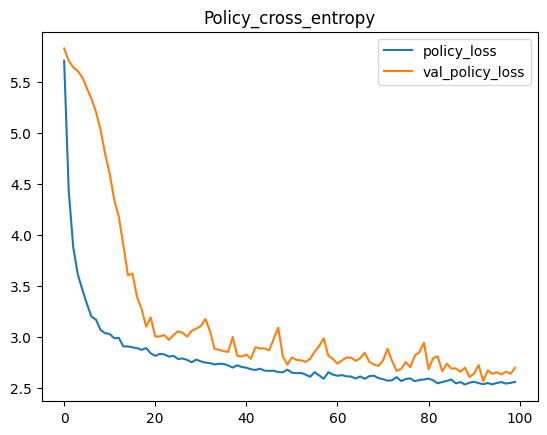

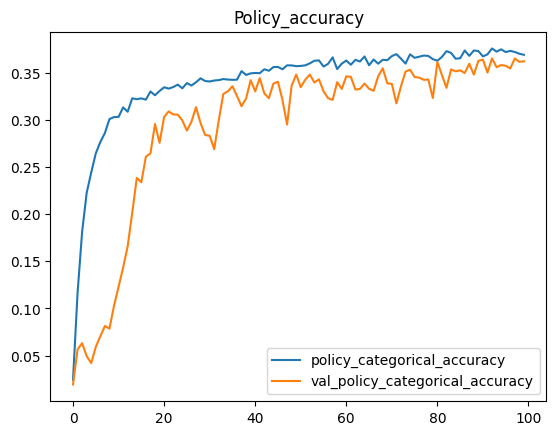

In [17]:
history_df_mobileNet.loc[0:, ['policy_loss', 'val_policy_loss']].plot(title="Policy_cross_entropy")
history_df_mobileNet.loc[:, ['policy_categorical_accuracy', 'val_policy_categorical_accuracy']].plot(
    title="Policy_accuracy")
print("Minimum Policy Validation Loss: {:0.4f}".format(history_df_mobileNet['val_policy_loss'].min()));
print("Maximum Policy Validation Accuracy: {:0.4f}".format(
    history_df_mobileNet['val_policy_categorical_accuracy'].max()));

Minimum Value Validation Loss: 0.6525
Minimum Value Validation MSE: 0.1017


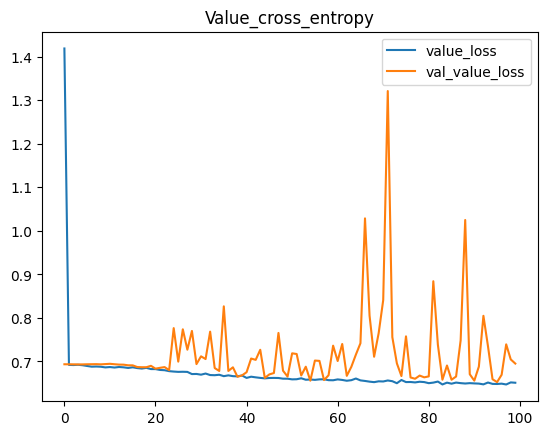

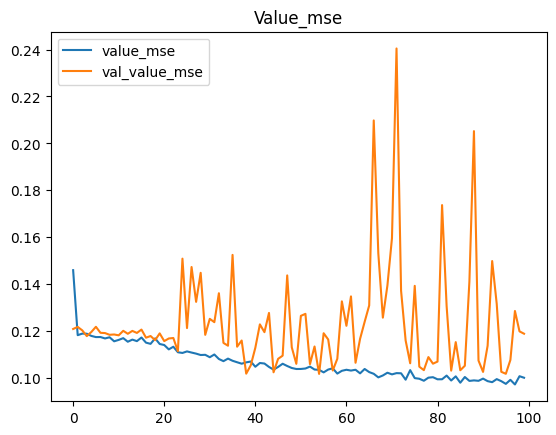

In [18]:
history_df_mobileNet.loc[0:, ['value_loss', 'val_value_loss']].plot(title="Value_cross_entropy")
history_df_mobileNet.loc[:, ['value_mse', 'val_value_mse']].plot(title="Value_mse")
print("Minimum Value Validation Loss: {:0.4f}".format(history_df_mobileNet['val_value_loss'].min()));
print("Minimum Value Validation MSE: {:0.4f}".format(history_df_mobileNet['val_value_mse'].min()));

## 2. Shuffle network

Entrainons un modèle ShuffleNet et notons ces performances.

In [4]:
batch = 256
filters = 6 * 32
trunk = 32
blocks = 14


def gconv(tensor, channels, groups):
    input_ch = tensor.get_shape().as_list()[-1]
    group_ch = input_ch // groups
    output_ch = channels // groups
    groups_list = []

    for i in range(groups):
        group_tensor = tensor[:, :, :, i * group_ch: (i + 1) * group_ch]
        group_tensor = Conv2D(output_ch, 1)(group_tensor)
        groups_list.append(group_tensor)

    output = Concatenate()(groups_list)
    return output


def channel_shuffle(x, groups):
    _, width, height, channels = x.get_shape().as_list()
    group_ch = channels // groups
    x = Reshape([width, height, group_ch, groups])(x)
    x = Permute([1, 2, 4, 3])(x)
    x = Reshape([width, height, channels])(x)
    return x


def bottleneck_block(tensor, expand=96, squeeze=16):
    x = gconv(tensor, channels=expand, groups=4)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = channel_shuffle(x, groups=4)
    x = DepthwiseConv2D(kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = gconv(x, channels=squeeze, groups=4)
    x = BatchNormalization()(x)
    x = Add()([tensor, x])
    output = ReLU()(x)
    return output

In [5]:
x = layers.Conv2D(trunk, 1, activation='relu', padding='same')(input)

for i in range(blocks):
    x = bottleneck_block(x, filters, trunk)

x = layers.BatchNormalization()(x)

policy_head = layers.Conv2D(1, 1, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
policy_head = layers.Flatten()(policy_head)
policy_head = layers.Activation('softmax', name='policy')(policy_head)

value_head = layers.GlobalAveragePooling2D()(x)
value_head = layers.Dense(50, activation='relu')(value_head)
value_head = layers.Dense(1, activation='sigmoid', name='value')(value_head)

model = keras.Model(inputs=input, outputs=[policy_head, value_head])

#model.summary()

2024-01-02 14:41:12.609788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-02 14:41:12.656058: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-02 14:41:12.656311: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss={'policy': 'categorical_crossentropy', 'value': 'binary_crossentropy'},
              loss_weights={'policy': 1.0, 'value': 9.0},
              metrics={'policy': 'categorical_accuracy', 'value': 'mse'})

# Sauvegarde de l'historique
csv_logger = tf.keras.callbacks.CSVLogger('./history_shuffleNet_Edy_Diehl_TCHEUTCHOA_DEFFO.csv', append=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001,  # minimium amount of change to count as an improvement
    patience=5,  # how many epochs to wait before stopping
    restore_best_weights=True,
)

for i in range(1, epochs + 1):
    print('epoch ' + str(i))
    golois.getBatch(input_data, policy, value, end, groups, i * N)
    history = model.fit(input_data,
                        {'policy': policy, 'value': value},
                        validation_split=0.2,
                        epochs=1, batch_size=batch, verbose=1, callbacks=[csv_logger, early_stopping])

    if (i % 2 == 0):
        gc.collect()
    if (i % 100 == 0):
        golois.getValidation(input_data, policy, value, end)
        val = model.evaluate(input_data, [policy, value], verbose=1, batch_size=batch)
        print("val =", val)
        model.save('./shuffleNet_Edy_Diehl_TCHEUTCHOA_DEFFO.h5')

epoch 1


r.shape = (30000, 19, 19, 31)
nbExamples = 30000
2024-01-02 14:41:56.015856: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-02 14:41:56.959020: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-02 14:41:57.056159: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-02 14:41:58.334715: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f161affc620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-02 14:41:58.334744: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-01-02 14:41:58.339943: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:17042065

94/94 [==============================] - 95s 523ms/step - loss: 10.8052 - policy_loss: 4.5728 - value_loss: 0.6923 - policy_categorical_accuracy: 0.0973 - value_mse: 0.1190 - val_loss: 11.7694 - val_policy_loss: 5.5309 - val_value_loss: 0.6929 - val_policy_categorical_accuracy: 0.0452 - val_value_mse: 0.1218
epoch 2


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 9.4206 - policy_loss: 3.2478 - value_loss: 0.6856 - policy_categorical_accuracy: 0.2635 - value_mse: 0.1159 - val_loss: 11.2316 - val_policy_loss: 4.9602 - val_value_loss: 0.6966 - val_policy_categorical_accuracy: 0.0805 - val_value_mse: 0.1214
epoch 3


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 495ms/step - loss: 9.1165 - policy_loss: 3.0690 - value_loss: 0.6717 - policy_categorical_accuracy: 0.2943 - value_mse: 0.1098 - val_loss: 10.1475 - val_policy_loss: 3.9632 - val_value_loss: 0.6869 - val_policy_categorical_accuracy: 0.1900 - val_value_mse: 0.1178
epoch 4


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.9044 - policy_loss: 2.9435 - value_loss: 0.6620 - policy_categorical_accuracy: 0.3124 - value_mse: 0.1051 - val_loss: 10.1802 - val_policy_loss: 3.3551 - val_value_loss: 0.7580 - val_policy_categorical_accuracy: 0.2510 - val_value_mse: 0.1348
epoch 5


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 495ms/step - loss: 8.8802 - policy_loss: 2.9194 - value_loss: 0.6620 - policy_categorical_accuracy: 0.3192 - value_mse: 0.1048 - val_loss: 9.9410 - val_policy_loss: 3.5430 - val_value_loss: 0.7106 - val_policy_categorical_accuracy: 0.2460 - val_value_mse: 0.1251
epoch 6


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 494ms/step - loss: 8.7961 - policy_loss: 2.8881 - value_loss: 0.6561 - policy_categorical_accuracy: 0.3220 - value_mse: 0.1017 - val_loss: 9.2762 - val_policy_loss: 3.1285 - val_value_loss: 0.6827 - val_policy_categorical_accuracy: 0.2873 - val_value_mse: 0.1160
epoch 7


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 495ms/step - loss: 8.7634 - policy_loss: 2.8582 - value_loss: 0.6558 - policy_categorical_accuracy: 0.3190 - value_mse: 0.1027 - val_loss: 9.5036 - val_policy_loss: 2.9445 - val_value_loss: 0.7284 - val_policy_categorical_accuracy: 0.3232 - val_value_mse: 0.1345
epoch 8


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.7234 - policy_loss: 2.8461 - value_loss: 0.6527 - policy_categorical_accuracy: 0.3255 - value_mse: 0.1004 - val_loss: 9.0212 - val_policy_loss: 2.9849 - val_value_loss: 0.6704 - val_policy_categorical_accuracy: 0.3175 - val_value_mse: 0.1064
epoch 9


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 495ms/step - loss: 8.6511 - policy_loss: 2.7917 - value_loss: 0.6507 - policy_categorical_accuracy: 0.3381 - value_mse: 0.1002 - val_loss: 9.7863 - val_policy_loss: 2.9084 - val_value_loss: 0.7639 - val_policy_categorical_accuracy: 0.3280 - val_value_mse: 0.1387
epoch 10


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.6090 - policy_loss: 2.7811 - value_loss: 0.6472 - policy_categorical_accuracy: 0.3346 - value_mse: 0.0984 - val_loss: 9.7441 - val_policy_loss: 2.8114 - val_value_loss: 0.7699 - val_policy_categorical_accuracy: 0.3382 - val_value_mse: 0.1422
epoch 11


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 494ms/step - loss: 8.5962 - policy_loss: 2.7550 - value_loss: 0.6487 - policy_categorical_accuracy: 0.3405 - value_mse: 0.0992 - val_loss: 11.6671 - val_policy_loss: 2.8246 - val_value_loss: 0.9821 - val_policy_categorical_accuracy: 0.3435 - val_value_mse: 0.1832
epoch 12


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 494ms/step - loss: 8.5677 - policy_loss: 2.7448 - value_loss: 0.6466 - policy_categorical_accuracy: 0.3421 - value_mse: 0.0993 - val_loss: 9.1328 - val_policy_loss: 2.9470 - val_value_loss: 0.6870 - val_policy_categorical_accuracy: 0.3213 - val_value_mse: 0.1141
epoch 13


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 495ms/step - loss: 8.5742 - policy_loss: 2.7551 - value_loss: 0.6462 - policy_categorical_accuracy: 0.3360 - value_mse: 0.0979 - val_loss: 8.7719 - val_policy_loss: 2.8464 - val_value_loss: 0.6580 - val_policy_categorical_accuracy: 0.3298 - val_value_mse: 0.1026
epoch 14


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 495ms/step - loss: 8.5323 - policy_loss: 2.7092 - value_loss: 0.6466 - policy_categorical_accuracy: 0.3472 - value_mse: 0.0990 - val_loss: 10.2295 - val_policy_loss: 2.7918 - val_value_loss: 0.8260 - val_policy_categorical_accuracy: 0.3387 - val_value_mse: 0.1551
epoch 15


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 494ms/step - loss: 8.5153 - policy_loss: 2.7190 - value_loss: 0.6436 - policy_categorical_accuracy: 0.3471 - value_mse: 0.0975 - val_loss: 8.7033 - val_policy_loss: 2.7546 - val_value_loss: 0.6606 - val_policy_categorical_accuracy: 0.3408 - val_value_mse: 0.1032
epoch 16


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 494ms/step - loss: 8.4970 - policy_loss: 2.6943 - value_loss: 0.6444 - policy_categorical_accuracy: 0.3530 - value_mse: 0.0979 - val_loss: 11.0381 - val_policy_loss: 2.7726 - val_value_loss: 0.9180 - val_policy_categorical_accuracy: 0.3442 - val_value_mse: 0.1703
epoch 17


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 495ms/step - loss: 8.4789 - policy_loss: 2.7167 - value_loss: 0.6399 - policy_categorical_accuracy: 0.3392 - value_mse: 0.0958 - val_loss: 8.6418 - val_policy_loss: 2.8276 - val_value_loss: 0.6456 - val_policy_categorical_accuracy: 0.3288 - val_value_mse: 0.0987
epoch 18


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 494ms/step - loss: 8.4870 - policy_loss: 2.7101 - value_loss: 0.6415 - policy_categorical_accuracy: 0.3450 - value_mse: 0.0963 - val_loss: 9.9627 - val_policy_loss: 2.8874 - val_value_loss: 0.7858 - val_policy_categorical_accuracy: 0.3310 - val_value_mse: 0.1462
epoch 19


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 494ms/step - loss: 8.4614 - policy_loss: 2.6706 - value_loss: 0.6430 - policy_categorical_accuracy: 0.3498 - value_mse: 0.0977 - val_loss: 9.0659 - val_policy_loss: 2.8290 - val_value_loss: 0.6926 - val_policy_categorical_accuracy: 0.3437 - val_value_mse: 0.1143
epoch 20


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 495ms/step - loss: 8.4581 - policy_loss: 2.6741 - value_loss: 0.6423 - policy_categorical_accuracy: 0.3492 - value_mse: 0.0968 - val_loss: 10.0803 - val_policy_loss: 2.8777 - val_value_loss: 0.7999 - val_policy_categorical_accuracy: 0.3335 - val_value_mse: 0.1518
epoch 21


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 495ms/step - loss: 8.4165 - policy_loss: 2.6733 - value_loss: 0.6377 - policy_categorical_accuracy: 0.3541 - value_mse: 0.0951 - val_loss: 8.9707 - val_policy_loss: 2.8250 - val_value_loss: 0.6825 - val_policy_categorical_accuracy: 0.3440 - val_value_mse: 0.1140
epoch 22


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.4261 - policy_loss: 2.6750 - value_loss: 0.6386 - policy_categorical_accuracy: 0.3487 - value_mse: 0.0942 - val_loss: 9.0201 - val_policy_loss: 2.7548 - val_value_loss: 0.6958 - val_policy_categorical_accuracy: 0.3370 - val_value_mse: 0.1208
epoch 23


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.3723 - policy_loss: 2.6567 - value_loss: 0.6347 - policy_categorical_accuracy: 0.3532 - value_mse: 0.0935 - val_loss: 8.6194 - val_policy_loss: 2.7377 - val_value_loss: 0.6531 - val_policy_categorical_accuracy: 0.3405 - val_value_mse: 0.1025
epoch 24


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 495ms/step - loss: 8.4107 - policy_loss: 2.6463 - value_loss: 0.6401 - policy_categorical_accuracy: 0.3544 - value_mse: 0.0951 - val_loss: 8.5462 - val_policy_loss: 2.6732 - val_value_loss: 0.6522 - val_policy_categorical_accuracy: 0.3468 - val_value_mse: 0.0998
epoch 25


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 494ms/step - loss: 8.3927 - policy_loss: 2.6375 - value_loss: 0.6391 - policy_categorical_accuracy: 0.3582 - value_mse: 0.0947 - val_loss: 8.5882 - val_policy_loss: 2.6730 - val_value_loss: 0.6569 - val_policy_categorical_accuracy: 0.3477 - val_value_mse: 0.1008
epoch 26


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.3647 - policy_loss: 2.6505 - value_loss: 0.6345 - policy_categorical_accuracy: 0.3554 - value_mse: 0.0930 - val_loss: 8.8357 - val_policy_loss: 2.7007 - val_value_loss: 0.6813 - val_policy_categorical_accuracy: 0.3513 - val_value_mse: 0.1119
epoch 27


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 495ms/step - loss: 8.4131 - policy_loss: 2.6303 - value_loss: 0.6421 - policy_categorical_accuracy: 0.3558 - value_mse: 0.0963 - val_loss: 8.7817 - val_policy_loss: 2.7580 - val_value_loss: 0.6689 - val_policy_categorical_accuracy: 0.3455 - val_value_mse: 0.1056
epoch 28


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 495ms/step - loss: 8.3589 - policy_loss: 2.6340 - value_loss: 0.6357 - policy_categorical_accuracy: 0.3530 - value_mse: 0.0942 - val_loss: 9.0192 - val_policy_loss: 2.7823 - val_value_loss: 0.6926 - val_policy_categorical_accuracy: 0.3483 - val_value_mse: 0.1163
epoch 29


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 495ms/step - loss: 8.3167 - policy_loss: 2.6103 - value_loss: 0.6336 - policy_categorical_accuracy: 0.3573 - value_mse: 0.0936 - val_loss: 9.2665 - val_policy_loss: 2.7047 - val_value_loss: 0.7287 - val_policy_categorical_accuracy: 0.3433 - val_value_mse: 0.1281
epoch 30


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.3259 - policy_loss: 2.6312 - value_loss: 0.6324 - policy_categorical_accuracy: 0.3585 - value_mse: 0.0936 - val_loss: 8.6655 - val_policy_loss: 2.7126 - val_value_loss: 0.6610 - val_policy_categorical_accuracy: 0.3413 - val_value_mse: 0.1047
epoch 31


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.2999 - policy_loss: 2.5911 - value_loss: 0.6339 - policy_categorical_accuracy: 0.3645 - value_mse: 0.0935 - val_loss: 9.4935 - val_policy_loss: 2.8298 - val_value_loss: 0.7400 - val_policy_categorical_accuracy: 0.3338 - val_value_mse: 0.1346
epoch 32


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.2962 - policy_loss: 2.6064 - value_loss: 0.6318 - policy_categorical_accuracy: 0.3580 - value_mse: 0.0926 - val_loss: 8.4116 - val_policy_loss: 2.6862 - val_value_loss: 0.6358 - val_policy_categorical_accuracy: 0.3443 - val_value_mse: 0.0954
epoch 33


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.2803 - policy_loss: 2.5996 - value_loss: 0.6308 - policy_categorical_accuracy: 0.3640 - value_mse: 0.0925 - val_loss: 8.5344 - val_policy_loss: 2.7041 - val_value_loss: 0.6474 - val_policy_categorical_accuracy: 0.3378 - val_value_mse: 0.0978
epoch 34


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.3181 - policy_loss: 2.6050 - value_loss: 0.6344 - policy_categorical_accuracy: 0.3593 - value_mse: 0.0931 - val_loss: 9.7505 - val_policy_loss: 2.7028 - val_value_loss: 0.7827 - val_policy_categorical_accuracy: 0.3520 - val_value_mse: 0.1408
epoch 35


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 494ms/step - loss: 8.2851 - policy_loss: 2.6071 - value_loss: 0.6305 - policy_categorical_accuracy: 0.3576 - value_mse: 0.0926 - val_loss: 8.7245 - val_policy_loss: 2.6881 - val_value_loss: 0.6703 - val_policy_categorical_accuracy: 0.3423 - val_value_mse: 0.1082
epoch 36


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 495ms/step - loss: 8.2564 - policy_loss: 2.5838 - value_loss: 0.6299 - policy_categorical_accuracy: 0.3647 - value_mse: 0.0926 - val_loss: 9.6733 - val_policy_loss: 2.6430 - val_value_loss: 0.7808 - val_policy_categorical_accuracy: 0.3638 - val_value_mse: 0.1424
epoch 37


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.2614 - policy_loss: 2.5876 - value_loss: 0.6300 - policy_categorical_accuracy: 0.3628 - value_mse: 0.0911 - val_loss: 9.4162 - val_policy_loss: 2.6350 - val_value_loss: 0.7531 - val_policy_categorical_accuracy: 0.3555 - val_value_mse: 0.1369
epoch 38


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.2825 - policy_loss: 2.5791 - value_loss: 0.6333 - policy_categorical_accuracy: 0.3647 - value_mse: 0.0927 - val_loss: 8.6035 - val_policy_loss: 2.6664 - val_value_loss: 0.6593 - val_policy_categorical_accuracy: 0.3537 - val_value_mse: 0.1027
epoch 39


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 495ms/step - loss: 8.2397 - policy_loss: 2.5854 - value_loss: 0.6279 - policy_categorical_accuracy: 0.3632 - value_mse: 0.0903 - val_loss: 10.5739 - val_policy_loss: 2.7394 - val_value_loss: 0.8701 - val_policy_categorical_accuracy: 0.3415 - val_value_mse: 0.1603
epoch 40


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 494ms/step - loss: 8.2676 - policy_loss: 2.5863 - value_loss: 0.6309 - policy_categorical_accuracy: 0.3647 - value_mse: 0.0916 - val_loss: 9.6446 - val_policy_loss: 2.6065 - val_value_loss: 0.7817 - val_policy_categorical_accuracy: 0.3565 - val_value_mse: 0.1279
epoch 41


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 494ms/step - loss: 8.1963 - policy_loss: 2.5645 - value_loss: 0.6254 - policy_categorical_accuracy: 0.3593 - value_mse: 0.0904 - val_loss: 8.9374 - val_policy_loss: 2.6183 - val_value_loss: 0.7017 - val_policy_categorical_accuracy: 0.3587 - val_value_mse: 0.1198
epoch 42


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 494ms/step - loss: 8.2132 - policy_loss: 2.5644 - value_loss: 0.6273 - policy_categorical_accuracy: 0.3656 - value_mse: 0.0912 - val_loss: 8.5311 - val_policy_loss: 2.6396 - val_value_loss: 0.6542 - val_policy_categorical_accuracy: 0.3605 - val_value_mse: 0.1004
epoch 43


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 494ms/step - loss: 8.1912 - policy_loss: 2.5517 - value_loss: 0.6262 - policy_categorical_accuracy: 0.3680 - value_mse: 0.0904 - val_loss: 9.6897 - val_policy_loss: 2.7208 - val_value_loss: 0.7739 - val_policy_categorical_accuracy: 0.3488 - val_value_mse: 0.1369
epoch 44


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.2161 - policy_loss: 2.5655 - value_loss: 0.6275 - policy_categorical_accuracy: 0.3656 - value_mse: 0.0906 - val_loss: 9.0479 - val_policy_loss: 2.6364 - val_value_loss: 0.7120 - val_policy_categorical_accuracy: 0.3598 - val_value_mse: 0.1167
epoch 45


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 494ms/step - loss: 8.1889 - policy_loss: 2.5470 - value_loss: 0.6265 - policy_categorical_accuracy: 0.3673 - value_mse: 0.0897 - val_loss: 13.3045 - val_policy_loss: 2.7129 - val_value_loss: 1.1765 - val_policy_categorical_accuracy: 0.3455 - val_value_mse: 0.2146
epoch 46


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.2161 - policy_loss: 2.5500 - value_loss: 0.6292 - policy_categorical_accuracy: 0.3690 - value_mse: 0.0913 - val_loss: 8.5006 - val_policy_loss: 2.5994 - val_value_loss: 0.6553 - val_policy_categorical_accuracy: 0.3682 - val_value_mse: 0.1022
epoch 47


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.2564 - policy_loss: 2.5614 - value_loss: 0.6324 - policy_categorical_accuracy: 0.3636 - value_mse: 0.0937 - val_loss: 9.1210 - val_policy_loss: 2.7169 - val_value_loss: 0.7112 - val_policy_categorical_accuracy: 0.3432 - val_value_mse: 0.1149
epoch 48


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.1757 - policy_loss: 2.5280 - value_loss: 0.6271 - policy_categorical_accuracy: 0.3681 - value_mse: 0.0902 - val_loss: 8.7591 - val_policy_loss: 2.6334 - val_value_loss: 0.6803 - val_policy_categorical_accuracy: 0.3505 - val_value_mse: 0.1114
epoch 49


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.1670 - policy_loss: 2.5415 - value_loss: 0.6247 - policy_categorical_accuracy: 0.3696 - value_mse: 0.0899 - val_loss: 9.0216 - val_policy_loss: 2.7076 - val_value_loss: 0.7012 - val_policy_categorical_accuracy: 0.3497 - val_value_mse: 0.1183
epoch 50


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.1957 - policy_loss: 2.5714 - value_loss: 0.6245 - policy_categorical_accuracy: 0.3636 - value_mse: 0.0892 - val_loss: 8.6193 - val_policy_loss: 2.6131 - val_value_loss: 0.6670 - val_policy_categorical_accuracy: 0.3698 - val_value_mse: 0.1052
epoch 51


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.1276 - policy_loss: 2.5231 - value_loss: 0.6223 - policy_categorical_accuracy: 0.3695 - value_mse: 0.0890 - val_loss: 9.2880 - val_policy_loss: 2.5964 - val_value_loss: 0.7431 - val_policy_categorical_accuracy: 0.3570 - val_value_mse: 0.1268
epoch 52


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.1190 - policy_loss: 2.5279 - value_loss: 0.6208 - policy_categorical_accuracy: 0.3731 - value_mse: 0.0879 - val_loss: 8.6532 - val_policy_loss: 2.6181 - val_value_loss: 0.6702 - val_policy_categorical_accuracy: 0.3587 - val_value_mse: 0.1055
epoch 53


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 46s 495ms/step - loss: 8.1394 - policy_loss: 2.5362 - value_loss: 0.6222 - policy_categorical_accuracy: 0.3730 - value_mse: 0.0889 - val_loss: 8.3130 - val_policy_loss: 2.6169 - val_value_loss: 0.6325 - val_policy_categorical_accuracy: 0.3648 - val_value_mse: 0.0919
epoch 54


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.1147 - policy_loss: 2.5253 - value_loss: 0.6207 - policy_categorical_accuracy: 0.3752 - value_mse: 0.0884 - val_loss: 9.4971 - val_policy_loss: 2.7216 - val_value_loss: 0.7525 - val_policy_categorical_accuracy: 0.3555 - val_value_mse: 0.1271
epoch 55


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.1161 - policy_loss: 2.5216 - value_loss: 0.6212 - policy_categorical_accuracy: 0.3714 - value_mse: 0.0894 - val_loss: 8.6729 - val_policy_loss: 2.6320 - val_value_loss: 0.6708 - val_policy_categorical_accuracy: 0.3633 - val_value_mse: 0.1079
epoch 56


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.1708 - policy_loss: 2.5410 - value_loss: 0.6252 - policy_categorical_accuracy: 0.3677 - value_mse: 0.0894 - val_loss: 9.1432 - val_policy_loss: 2.6850 - val_value_loss: 0.7172 - val_policy_categorical_accuracy: 0.3515 - val_value_mse: 0.1186
epoch 57


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.1272 - policy_loss: 2.5213 - value_loss: 0.6225 - policy_categorical_accuracy: 0.3732 - value_mse: 0.0880 - val_loss: 9.0265 - val_policy_loss: 2.6813 - val_value_loss: 0.7047 - val_policy_categorical_accuracy: 0.3473 - val_value_mse: 0.1144
epoch 58


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0929 - policy_loss: 2.5015 - value_loss: 0.6209 - policy_categorical_accuracy: 0.3765 - value_mse: 0.0884 - val_loss: 9.9632 - val_policy_loss: 2.6246 - val_value_loss: 0.8150 - val_policy_categorical_accuracy: 0.3647 - val_value_mse: 0.1440
epoch 59


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.1294 - policy_loss: 2.5307 - value_loss: 0.6217 - policy_categorical_accuracy: 0.3685 - value_mse: 0.0885 - val_loss: 8.3785 - val_policy_loss: 2.6324 - val_value_loss: 0.6381 - val_policy_categorical_accuracy: 0.3607 - val_value_mse: 0.0959
epoch 60


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0911 - policy_loss: 2.5308 - value_loss: 0.6174 - policy_categorical_accuracy: 0.3707 - value_mse: 0.0873 - val_loss: 8.3449 - val_policy_loss: 2.5879 - val_value_loss: 0.6393 - val_policy_categorical_accuracy: 0.3588 - val_value_mse: 0.0980
epoch 61


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0981 - policy_loss: 2.5043 - value_loss: 0.6212 - policy_categorical_accuracy: 0.3763 - value_mse: 0.0886 - val_loss: 8.5742 - val_policy_loss: 2.6136 - val_value_loss: 0.6619 - val_policy_categorical_accuracy: 0.3552 - val_value_mse: 0.1036
epoch 62


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.1023 - policy_loss: 2.5127 - value_loss: 0.6207 - policy_categorical_accuracy: 0.3702 - value_mse: 0.0880 - val_loss: 8.9791 - val_policy_loss: 2.5909 - val_value_loss: 0.7094 - val_policy_categorical_accuracy: 0.3678 - val_value_mse: 0.1114
epoch 63


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0884 - policy_loss: 2.5160 - value_loss: 0.6188 - policy_categorical_accuracy: 0.3758 - value_mse: 0.0889 - val_loss: 9.0382 - val_policy_loss: 2.5783 - val_value_loss: 0.7174 - val_policy_categorical_accuracy: 0.3700 - val_value_mse: 0.1193
epoch 64


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0533 - policy_loss: 2.5087 - value_loss: 0.6157 - policy_categorical_accuracy: 0.3741 - value_mse: 0.0863 - val_loss: 8.6269 - val_policy_loss: 2.6059 - val_value_loss: 0.6686 - val_policy_categorical_accuracy: 0.3602 - val_value_mse: 0.1101
epoch 65


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.1339 - policy_loss: 2.5383 - value_loss: 0.6213 - policy_categorical_accuracy: 0.3701 - value_mse: 0.0886 - val_loss: 8.3923 - val_policy_loss: 2.5191 - val_value_loss: 0.6522 - val_policy_categorical_accuracy: 0.3690 - val_value_mse: 0.1032
epoch 66


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0889 - policy_loss: 2.5209 - value_loss: 0.6183 - policy_categorical_accuracy: 0.3667 - value_mse: 0.0865 - val_loss: 9.6970 - val_policy_loss: 2.5561 - val_value_loss: 0.7931 - val_policy_categorical_accuracy: 0.3690 - val_value_mse: 0.1419
epoch 67


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0671 - policy_loss: 2.4887 - value_loss: 0.6195 - policy_categorical_accuracy: 0.3788 - value_mse: 0.0881 - val_loss: 8.1858 - val_policy_loss: 2.5890 - val_value_loss: 0.6215 - val_policy_categorical_accuracy: 0.3675 - val_value_mse: 0.0891
epoch 68


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0716 - policy_loss: 2.5186 - value_loss: 0.6166 - policy_categorical_accuracy: 0.3736 - value_mse: 0.0859 - val_loss: 8.5178 - val_policy_loss: 2.5899 - val_value_loss: 0.6583 - val_policy_categorical_accuracy: 0.3723 - val_value_mse: 0.1015
epoch 69


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0567 - policy_loss: 2.4950 - value_loss: 0.6176 - policy_categorical_accuracy: 0.3762 - value_mse: 0.0883 - val_loss: 9.7104 - val_policy_loss: 2.6701 - val_value_loss: 0.7819 - val_policy_categorical_accuracy: 0.3670 - val_value_mse: 0.1417
epoch 70


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.0763 - policy_loss: 2.4998 - value_loss: 0.6192 - policy_categorical_accuracy: 0.3736 - value_mse: 0.0879 - val_loss: 10.0194 - val_policy_loss: 2.6846 - val_value_loss: 0.8146 - val_policy_categorical_accuracy: 0.3552 - val_value_mse: 0.1506
epoch 71


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 7.9998 - policy_loss: 2.4995 - value_loss: 0.6108 - policy_categorical_accuracy: 0.3771 - value_mse: 0.0856 - val_loss: 9.3215 - val_policy_loss: 2.6963 - val_value_loss: 0.7358 - val_policy_categorical_accuracy: 0.3448 - val_value_mse: 0.1222
epoch 72


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.0343 - policy_loss: 2.5023 - value_loss: 0.6143 - policy_categorical_accuracy: 0.3725 - value_mse: 0.0853 - val_loss: 8.6064 - val_policy_loss: 2.6393 - val_value_loss: 0.6626 - val_policy_categorical_accuracy: 0.3555 - val_value_mse: 0.1048
epoch 73


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0336 - policy_loss: 2.4924 - value_loss: 0.6153 - policy_categorical_accuracy: 0.3778 - value_mse: 0.0871 - val_loss: 8.6939 - val_policy_loss: 2.6462 - val_value_loss: 0.6716 - val_policy_categorical_accuracy: 0.3530 - val_value_mse: 0.1048
epoch 74


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0232 - policy_loss: 2.5000 - value_loss: 0.6133 - policy_categorical_accuracy: 0.3743 - value_mse: 0.0850 - val_loss: 8.6259 - val_policy_loss: 2.5379 - val_value_loss: 0.6761 - val_policy_categorical_accuracy: 0.3735 - val_value_mse: 0.1062
epoch 75


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0357 - policy_loss: 2.4866 - value_loss: 0.6162 - policy_categorical_accuracy: 0.3778 - value_mse: 0.0868 - val_loss: 10.7112 - val_policy_loss: 2.6667 - val_value_loss: 0.8935 - val_policy_categorical_accuracy: 0.3488 - val_value_mse: 0.1612
epoch 76


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.0430 - policy_loss: 2.5004 - value_loss: 0.6155 - policy_categorical_accuracy: 0.3739 - value_mse: 0.0861 - val_loss: 9.3472 - val_policy_loss: 2.6105 - val_value_loss: 0.7482 - val_policy_categorical_accuracy: 0.3685 - val_value_mse: 0.1261
epoch 77


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 8.0351 - policy_loss: 2.4919 - value_loss: 0.6156 - policy_categorical_accuracy: 0.3756 - value_mse: 0.0854 - val_loss: 11.7666 - val_policy_loss: 2.7078 - val_value_loss: 1.0062 - val_policy_categorical_accuracy: 0.3520 - val_value_mse: 0.1604
epoch 78


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0456 - policy_loss: 2.4741 - value_loss: 0.6187 - policy_categorical_accuracy: 0.3788 - value_mse: 0.0873 - val_loss: 18.2245 - val_policy_loss: 2.6118 - val_value_loss: 1.7344 - val_policy_categorical_accuracy: 0.3715 - val_value_mse: 0.2665
epoch 79


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0430 - policy_loss: 2.4950 - value_loss: 0.6161 - policy_categorical_accuracy: 0.3761 - value_mse: 0.0861 - val_loss: 14.6369 - val_policy_loss: 2.5861 - val_value_loss: 1.3386 - val_policy_categorical_accuracy: 0.3685 - val_value_mse: 0.2195
epoch 80


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0569 - policy_loss: 2.4990 - value_loss: 0.6172 - policy_categorical_accuracy: 0.3730 - value_mse: 0.0857 - val_loss: 9.1700 - val_policy_loss: 2.6676 - val_value_loss: 0.7221 - val_policy_categorical_accuracy: 0.3598 - val_value_mse: 0.1168
epoch 81


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0403 - policy_loss: 2.5004 - value_loss: 0.6152 - policy_categorical_accuracy: 0.3698 - value_mse: 0.0854 - val_loss: 9.3929 - val_policy_loss: 2.5811 - val_value_loss: 0.7565 - val_policy_categorical_accuracy: 0.3693 - val_value_mse: 0.1323
epoch 82


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0126 - policy_loss: 2.4915 - value_loss: 0.6131 - policy_categorical_accuracy: 0.3765 - value_mse: 0.0857 - val_loss: 8.0869 - val_policy_loss: 2.5284 - val_value_loss: 0.6172 - val_policy_categorical_accuracy: 0.3667 - val_value_mse: 0.0878
epoch 83


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 7.9412 - policy_loss: 2.4662 - value_loss: 0.6080 - policy_categorical_accuracy: 0.3815 - value_mse: 0.0829 - val_loss: 8.4072 - val_policy_loss: 2.5471 - val_value_loss: 0.6508 - val_policy_categorical_accuracy: 0.3730 - val_value_mse: 0.1005
epoch 84


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 7.9524 - policy_loss: 2.4695 - value_loss: 0.6089 - policy_categorical_accuracy: 0.3785 - value_mse: 0.0832 - val_loss: 9.5161 - val_policy_loss: 2.5818 - val_value_loss: 0.7702 - val_policy_categorical_accuracy: 0.3627 - val_value_mse: 0.1439
epoch 85


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0155 - policy_loss: 2.4677 - value_loss: 0.6161 - policy_categorical_accuracy: 0.3785 - value_mse: 0.0867 - val_loss: 13.7898 - val_policy_loss: 2.6053 - val_value_loss: 1.2424 - val_policy_categorical_accuracy: 0.3640 - val_value_mse: 0.2430
epoch 86


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 7.9866 - policy_loss: 2.4823 - value_loss: 0.6112 - policy_categorical_accuracy: 0.3727 - value_mse: 0.0839 - val_loss: 9.4156 - val_policy_loss: 2.6901 - val_value_loss: 0.7469 - val_policy_categorical_accuracy: 0.3542 - val_value_mse: 0.1362
epoch 87


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0344 - policy_loss: 2.4896 - value_loss: 0.6157 - policy_categorical_accuracy: 0.3725 - value_mse: 0.0854 - val_loss: 9.6350 - val_policy_loss: 2.5988 - val_value_loss: 0.7815 - val_policy_categorical_accuracy: 0.3588 - val_value_mse: 0.1369
epoch 88


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 8.0494 - policy_loss: 2.4805 - value_loss: 0.6184 - policy_categorical_accuracy: 0.3748 - value_mse: 0.0865 - val_loss: 9.7651 - val_policy_loss: 2.5133 - val_value_loss: 0.8054 - val_policy_categorical_accuracy: 0.3690 - val_value_mse: 0.1441
epoch 89


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 7.9632 - policy_loss: 2.4585 - value_loss: 0.6113 - policy_categorical_accuracy: 0.3794 - value_mse: 0.0833 - val_loss: 13.6637 - val_policy_loss: 2.5976 - val_value_loss: 1.2292 - val_policy_categorical_accuracy: 0.3690 - val_value_mse: 0.1712
epoch 90


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 7.9860 - policy_loss: 2.4614 - value_loss: 0.6135 - policy_categorical_accuracy: 0.3774 - value_mse: 0.0847 - val_loss: 8.8829 - val_policy_loss: 2.5696 - val_value_loss: 0.7011 - val_policy_categorical_accuracy: 0.3642 - val_value_mse: 0.1140
epoch 91


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 7.9795 - policy_loss: 2.4807 - value_loss: 0.6106 - policy_categorical_accuracy: 0.3769 - value_mse: 0.0844 - val_loss: 8.6839 - val_policy_loss: 2.5399 - val_value_loss: 0.6823 - val_policy_categorical_accuracy: 0.3743 - val_value_mse: 0.1143
epoch 92


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 7.9618 - policy_loss: 2.4621 - value_loss: 0.6107 - policy_categorical_accuracy: 0.3785 - value_mse: 0.0838 - val_loss: 10.7601 - val_policy_loss: 2.5858 - val_value_loss: 0.9079 - val_policy_categorical_accuracy: 0.3708 - val_value_mse: 0.1529
epoch 93


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 7.9591 - policy_loss: 2.4449 - value_loss: 0.6123 - policy_categorical_accuracy: 0.3838 - value_mse: 0.0848 - val_loss: 8.5535 - val_policy_loss: 2.4564 - val_value_loss: 0.6771 - val_policy_categorical_accuracy: 0.3757 - val_value_mse: 0.1102
epoch 94


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 495ms/step - loss: 7.9988 - policy_loss: 2.4866 - value_loss: 0.6121 - policy_categorical_accuracy: 0.3737 - value_mse: 0.0849 - val_loss: 8.2357 - val_policy_loss: 2.5615 - val_value_loss: 0.6301 - val_policy_categorical_accuracy: 0.3672 - val_value_mse: 0.0906
epoch 95


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 7.9928 - policy_loss: 2.4554 - value_loss: 0.6149 - policy_categorical_accuracy: 0.3813 - value_mse: 0.0870 - val_loss: 8.5906 - val_policy_loss: 2.5010 - val_value_loss: 0.6763 - val_policy_categorical_accuracy: 0.3798 - val_value_mse: 0.1069
epoch 96


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 7.9451 - policy_loss: 2.4732 - value_loss: 0.6076 - policy_categorical_accuracy: 0.3735 - value_mse: 0.0821 - val_loss: 8.7398 - val_policy_loss: 2.6258 - val_value_loss: 0.6790 - val_policy_categorical_accuracy: 0.3667 - val_value_mse: 0.1069
epoch 97


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 7.9628 - policy_loss: 2.4675 - value_loss: 0.6102 - policy_categorical_accuracy: 0.3828 - value_mse: 0.0835 - val_loss: 8.7779 - val_policy_loss: 2.5466 - val_value_loss: 0.6920 - val_policy_categorical_accuracy: 0.3665 - val_value_mse: 0.1081
epoch 98


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 7.9718 - policy_loss: 2.4535 - value_loss: 0.6128 - policy_categorical_accuracy: 0.3815 - value_mse: 0.0841 - val_loss: 8.7426 - val_policy_loss: 2.5135 - val_value_loss: 0.6918 - val_policy_categorical_accuracy: 0.3798 - val_value_mse: 0.1166
epoch 99


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 7.9689 - policy_loss: 2.4568 - value_loss: 0.6121 - policy_categorical_accuracy: 0.3822 - value_mse: 0.0852 - val_loss: 8.1689 - val_policy_loss: 2.5158 - val_value_loss: 0.6278 - val_policy_categorical_accuracy: 0.3658 - val_value_mse: 0.0923
epoch 100


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


94/94 [==============================] - 47s 496ms/step - loss: 7.9064 - policy_loss: 2.4517 - value_loss: 0.6057 - policy_categorical_accuracy: 0.3830 - value_mse: 0.0824 - val_loss: 11.6503 - val_policy_loss: 2.5142 - val_value_loss: 1.0148 - val_policy_categorical_accuracy: 0.3763 - val_value_mse: 0.1939


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


118/118 [==============================] - 18s 132ms/step - loss: 11.6476 - policy_loss: 2.5191 - value_loss: 1.0139 - policy_categorical_accuracy: 0.3729 - value_mse: 0.1943
val = [11.647640228271484, 2.519108533859253, 1.0139331817626953, 0.37290000915527344, 0.1942604035139084]


/opt/saturncloud/envs/saturn/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Pour les données de test, nous obtenons un modèle ShuffleNet avec une Accuracy de 0.3729 pour la Policy et un MSE de 0.1942 pour la Value.

In [7]:
history_df_shuffleNet = pd.read_csv('./history_shuffleNet_Edy_Diehl_TCHEUTCHOA_DEFFO.csv')
history_df_shuffleNet.columns

Index(['epoch', 'loss', 'policy_categorical_accuracy', 'policy_loss',
       'val_loss', 'val_policy_categorical_accuracy', 'val_policy_loss',
       'val_value_loss', 'val_value_mse', 'value_loss', 'value_mse'],
      dtype='object')

Minimum Policy Validation Loss: 2.4564
Maximum Policy Validation Accuracy: 0.3798


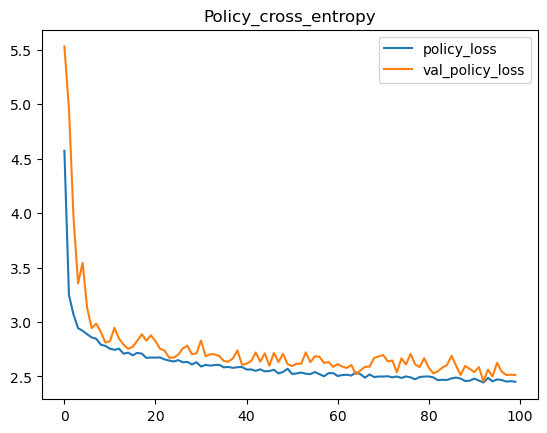

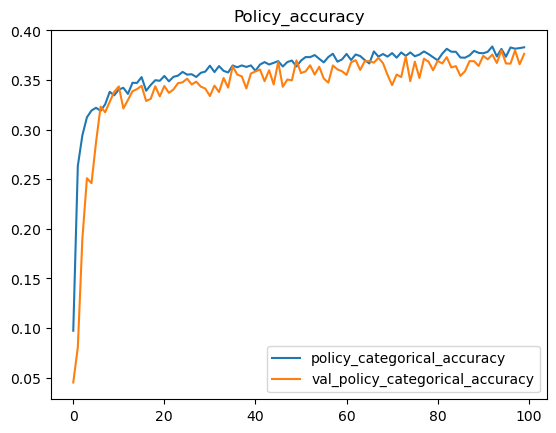

In [8]:
history_df_shuffleNet.loc[0:, ['policy_loss', 'val_policy_loss']].plot(title="Policy_cross_entropy")
history_df_shuffleNet.loc[:, ['policy_categorical_accuracy', 'val_policy_categorical_accuracy']].plot(
    title="Policy_accuracy")
print("Minimum Policy Validation Loss: {:0.4f}".format(history_df_shuffleNet['val_policy_loss'].min()));
print("Maximum Policy Validation Accuracy: {:0.4f}".format(
    history_df_shuffleNet['val_policy_categorical_accuracy'].max()));

Minimum Value Validation Loss: 0.6172
Minimum Value Validation MSE: 0.0878


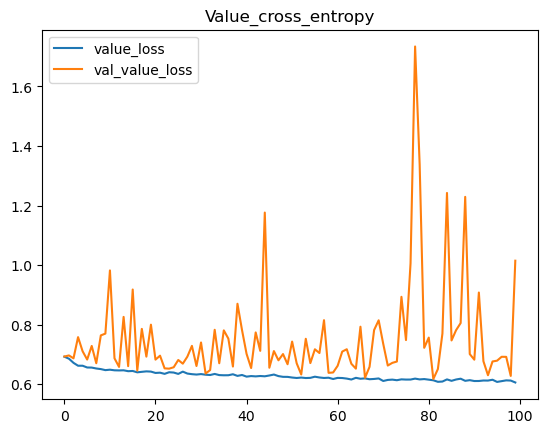

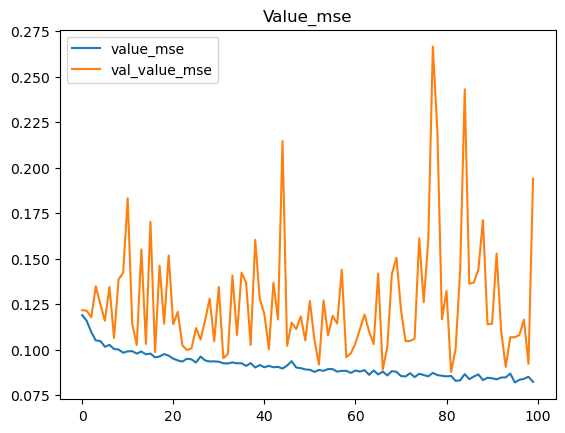

In [9]:
history_df_shuffleNet.loc[0:, ['value_loss', 'val_value_loss']].plot(title="Value_cross_entropy")
history_df_shuffleNet.loc[:, ['value_mse', 'val_value_mse']].plot(title="Value_mse")
print("Minimum Value Validation Loss: {:0.4f}".format(history_df_shuffleNet['val_value_loss'].min()));
print("Minimum Value Validation MSE: {:0.4f}".format(history_df_shuffleNet['val_value_mse'].min()));

## 3. Residual network

Entrainons un modèle ResidualNet et notons ces performances.

In [3]:
batch = 1024
filters = 32


def SE_block(t, filters, ratio=16):
    se_shape = (1, 1, filters)
    se = GlobalAveragePooling2D()(t)
    se = Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', use_bias=False)(se)
    x = layers.Multiply()([t, se])
    return x


def bottleneck_block(x, expand=6 * filters, squeeze=filters):
    m = layers.Conv2D(expand, (1, 1), use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = layers.Activation('relu')(m)
    m = layers.DepthwiseConv2D((3, 3), padding='same', use_bias=False)(m)
    m = layers.BatchNormalization()(m)
    m = layers.Activation('relu')(m)
    m = layers.Conv2D(squeeze, (1, 1), use_bias=False)(m)
    m = layers.BatchNormalization()(m)
    return layers.Add()([m, x])


def bottleneck_block_res(x, expand=6 * filters, squeeze=filters):
    m = layers.Conv2D(expand, (1, 1), use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = layers.Activation('relu')(m)
    m = layers.DepthwiseConv2D((3, 3), padding='same', use_bias=False)(m)
    m = layers.BatchNormalization()(m)
    m = layers.Activation('relu')(m)
    m = layers.Conv2D(squeeze, (1, 1), use_bias=False)(m)
    m = layers.BatchNormalization()(m)
    m = SE_block(m, filters)
    return layers.Add()([m, x])

In [4]:
x = layers.Conv2D(filters, 1, activation='relu', padding='same')(input)

for i in range(5):
    x = bottleneck_block_res(x)

policy_head = layers.Conv2D(1, 1, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
policy_head = layers.Flatten()(policy_head)
policy_head = layers.Activation('softmax', name='policy')(policy_head)

value_head = layers.Conv2D(1, 1, activation='relu', padding='same')(x)
value_head = layers.Flatten()(value_head)
value_head = layers.Dense(50, activation='relu')(value_head)
value_head = layers.Dense(1, activation='sigmoid', name='value')(value_head)

model = keras.Model(inputs=input, outputs=[policy_head, value_head])

#model.summary()

2024-01-02 17:07:38.813142: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-02 17:07:38.859853: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-02 17:07:38.860154: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0008),
              loss={'policy': 'categorical_crossentropy', 'value': 'binary_crossentropy'},
              loss_weights={'policy': 1.0, 'value': 9.0},
              metrics={'policy': 'categorical_accuracy', 'value': 'mse'})

# Sauvegarde de l'historique
csv_logger = tf.keras.callbacks.CSVLogger(
    './history_residualNet_Edy_Diehl_TCHEUTCHOA_DEFFO.csv', append=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001,  # minimium amount of change to count as an improvement
    patience=5,  # how many epochs to wait before stopping
    restore_best_weights=True,
)

for i in range(1, epochs + 1):
    print('epoch ' + str(i))
    golois.getBatch(input_data, policy, value, end, groups, i * N)
    history = model.fit(input_data,
                        {'policy': policy, 'value': value},
                        validation_split=0.2,
                        epochs=1, batch_size=batch, verbose=1, callbacks=[csv_logger, early_stopping])

    if (i % 2 == 0):
        gc.collect()
    if (i % 100 == 0):
        golois.getValidation(input_data, policy, value, end)
        val = model.evaluate(input_data,
                             [policy, value], verbose=1, batch_size=batch)
        print("val =", val)
        model.save('./residualNet_Edy_Diehl_TCHEUTCHOA_DEFFO.h5')

epoch 1


r.shape = (30000, 19, 19, 31)
nbExamples = 30000
2024-01-02 17:09:22.903113: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-02 17:09:23.887203: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-02 17:09:24.026371: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-02 17:09:25.222770: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc2c0846310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-02 17:09:25.222817: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-01-02 17:09:25.230751: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:17042153

24/24 [==============================] - 27s 566ms/step - loss: 12.6100 - policy_loss: 5.7312 - value_loss: 0.7641 - policy_categorical_accuracy: 0.0150 - value_mse: 0.1454 - val_loss: 12.0851 - val_policy_loss: 5.8430 - val_value_loss: 0.6934 - val_policy_categorical_accuracy: 0.0173 - val_value_mse: 0.1220
epoch 2


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 473ms/step - loss: 11.2916 - policy_loss: 5.0009 - value_loss: 0.6988 - policy_categorical_accuracy: 0.0495 - value_mse: 0.1223 - val_loss: 12.0395 - val_policy_loss: 5.7986 - val_value_loss: 0.6933 - val_policy_categorical_accuracy: 0.0223 - val_value_mse: 0.1198
epoch 3


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 10.6785 - policy_loss: 4.4452 - value_loss: 0.6924 - policy_categorical_accuracy: 0.1007 - value_mse: 0.1198 - val_loss: 11.9989 - val_policy_loss: 5.7586 - val_value_loss: 0.6932 - val_policy_categorical_accuracy: 0.0268 - val_value_mse: 0.1209
epoch 4


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 10.3092 - policy_loss: 4.0938 - value_loss: 0.6904 - policy_categorical_accuracy: 0.1426 - value_mse: 0.1185 - val_loss: 11.9683 - val_policy_loss: 5.7287 - val_value_loss: 0.6931 - val_policy_categorical_accuracy: 0.0318 - val_value_mse: 0.1173
epoch 5


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 10.0966 - policy_loss: 3.8882 - value_loss: 0.6897 - policy_categorical_accuracy: 0.1698 - value_mse: 0.1179 - val_loss: 11.9377 - val_policy_loss: 5.6982 - val_value_loss: 0.6931 - val_policy_categorical_accuracy: 0.0415 - val_value_mse: 0.1198
epoch 6


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 9.9519 - policy_loss: 3.7445 - value_loss: 0.6895 - policy_categorical_accuracy: 0.1970 - value_mse: 0.1173 - val_loss: 11.9125 - val_policy_loss: 5.6722 - val_value_loss: 0.6932 - val_policy_categorical_accuracy: 0.0485 - val_value_mse: 0.1225
epoch 7


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 9.8292 - policy_loss: 3.6363 - value_loss: 0.6879 - policy_categorical_accuracy: 0.2140 - value_mse: 0.1177 - val_loss: 11.8861 - val_policy_loss: 5.6456 - val_value_loss: 0.6932 - val_policy_categorical_accuracy: 0.0615 - val_value_mse: 0.1196
epoch 8


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 9.7232 - policy_loss: 3.5219 - value_loss: 0.6889 - policy_categorical_accuracy: 0.2303 - value_mse: 0.1172 - val_loss: 11.8451 - val_policy_loss: 5.6051 - val_value_loss: 0.6932 - val_policy_categorical_accuracy: 0.0717 - val_value_mse: 0.1184
epoch 9


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 9.6185 - policy_loss: 3.4149 - value_loss: 0.6891 - policy_categorical_accuracy: 0.2506 - value_mse: 0.1178 - val_loss: 11.8014 - val_policy_loss: 5.5613 - val_value_loss: 0.6932 - val_policy_categorical_accuracy: 0.0870 - val_value_mse: 0.1193
epoch 10


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 9.5343 - policy_loss: 3.3404 - value_loss: 0.6880 - policy_categorical_accuracy: 0.2618 - value_mse: 0.1170 - val_loss: 11.7464 - val_policy_loss: 5.5065 - val_value_loss: 0.6931 - val_policy_categorical_accuracy: 0.0922 - val_value_mse: 0.1204
epoch 11


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 477ms/step - loss: 9.4652 - policy_loss: 3.2752 - value_loss: 0.6876 - policy_categorical_accuracy: 0.2720 - value_mse: 0.1171 - val_loss: 11.6719 - val_policy_loss: 5.4322 - val_value_loss: 0.6931 - val_policy_categorical_accuracy: 0.0987 - val_value_mse: 0.1179
epoch 12


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 9.4046 - policy_loss: 3.2152 - value_loss: 0.6875 - policy_categorical_accuracy: 0.2822 - value_mse: 0.1178 - val_loss: 11.5870 - val_policy_loss: 5.3472 - val_value_loss: 0.6931 - val_policy_categorical_accuracy: 0.1028 - val_value_mse: 0.1187
epoch 13


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 477ms/step - loss: 9.4003 - policy_loss: 3.2099 - value_loss: 0.6876 - policy_categorical_accuracy: 0.2814 - value_mse: 0.1166 - val_loss: 11.4876 - val_policy_loss: 5.2482 - val_value_loss: 0.6931 - val_policy_categorical_accuracy: 0.1047 - val_value_mse: 0.1192
epoch 14


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 9.3216 - policy_loss: 3.1346 - value_loss: 0.6873 - policy_categorical_accuracy: 0.2910 - value_mse: 0.1176 - val_loss: 11.3526 - val_policy_loss: 5.1128 - val_value_loss: 0.6931 - val_policy_categorical_accuracy: 0.1128 - val_value_mse: 0.1206
epoch 15


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 9.2913 - policy_loss: 3.1070 - value_loss: 0.6870 - policy_categorical_accuracy: 0.2960 - value_mse: 0.1169 - val_loss: 11.1981 - val_policy_loss: 4.9581 - val_value_loss: 0.6931 - val_policy_categorical_accuracy: 0.1317 - val_value_mse: 0.1191
epoch 16


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 477ms/step - loss: 9.2444 - policy_loss: 3.0652 - value_loss: 0.6864 - policy_categorical_accuracy: 0.3009 - value_mse: 0.1169 - val_loss: 11.0435 - val_policy_loss: 4.8034 - val_value_loss: 0.6931 - val_policy_categorical_accuracy: 0.1327 - val_value_mse: 0.1216
epoch 17


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 9.2397 - policy_loss: 3.0604 - value_loss: 0.6864 - policy_categorical_accuracy: 0.3020 - value_mse: 0.1166 - val_loss: 10.8702 - val_policy_loss: 4.6319 - val_value_loss: 0.6929 - val_policy_categorical_accuracy: 0.1453 - val_value_mse: 0.1213
epoch 18


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 9.2264 - policy_loss: 3.0480 - value_loss: 0.6863 - policy_categorical_accuracy: 0.3027 - value_mse: 0.1164 - val_loss: 10.6655 - val_policy_loss: 4.4269 - val_value_loss: 0.6930 - val_policy_categorical_accuracy: 0.1838 - val_value_mse: 0.1221
epoch 19


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 9.1928 - policy_loss: 3.0085 - value_loss: 0.6869 - policy_categorical_accuracy: 0.3067 - value_mse: 0.1175 - val_loss: 10.4343 - val_policy_loss: 4.1996 - val_value_loss: 0.6925 - val_policy_categorical_accuracy: 0.1998 - val_value_mse: 0.1174
epoch 20


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 9.1470 - policy_loss: 2.9734 - value_loss: 0.6858 - policy_categorical_accuracy: 0.3112 - value_mse: 0.1163 - val_loss: 10.1980 - val_policy_loss: 3.9637 - val_value_loss: 0.6925 - val_policy_categorical_accuracy: 0.2130 - val_value_mse: 0.1194
epoch 21


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 9.1417 - policy_loss: 2.9605 - value_loss: 0.6866 - policy_categorical_accuracy: 0.3166 - value_mse: 0.1167 - val_loss: 9.9619 - val_policy_loss: 3.7388 - val_value_loss: 0.6913 - val_policy_categorical_accuracy: 0.2350 - val_value_mse: 0.1214
epoch 22


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 9.1156 - policy_loss: 2.9534 - value_loss: 0.6845 - policy_categorical_accuracy: 0.3165 - value_mse: 0.1144 - val_loss: 9.7929 - val_policy_loss: 3.5743 - val_value_loss: 0.6908 - val_policy_categorical_accuracy: 0.2468 - val_value_mse: 0.1220
epoch 23


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 477ms/step - loss: 9.0970 - policy_loss: 2.9357 - value_loss: 0.6844 - policy_categorical_accuracy: 0.3178 - value_mse: 0.1153 - val_loss: 9.5818 - val_policy_loss: 3.3727 - val_value_loss: 0.6897 - val_policy_categorical_accuracy: 0.2643 - val_value_mse: 0.1195
epoch 24


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 9.0765 - policy_loss: 2.9065 - value_loss: 0.6854 - policy_categorical_accuracy: 0.3257 - value_mse: 0.1152 - val_loss: 9.4200 - val_policy_loss: 3.2261 - val_value_loss: 0.6880 - val_policy_categorical_accuracy: 0.2850 - val_value_mse: 0.1168
epoch 25


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 9.0563 - policy_loss: 2.9036 - value_loss: 0.6834 - policy_categorical_accuracy: 0.3250 - value_mse: 0.1141 - val_loss: 9.2747 - val_policy_loss: 3.1274 - val_value_loss: 0.6828 - val_policy_categorical_accuracy: 0.2947 - val_value_mse: 0.1139
epoch 26


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 9.0219 - policy_loss: 2.8947 - value_loss: 0.6806 - policy_categorical_accuracy: 0.3233 - value_mse: 0.1132 - val_loss: 9.2762 - val_policy_loss: 3.0659 - val_value_loss: 0.6898 - val_policy_categorical_accuracy: 0.3013 - val_value_mse: 0.1167
epoch 27


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.9946 - policy_loss: 2.8836 - value_loss: 0.6788 - policy_categorical_accuracy: 0.3248 - value_mse: 0.1125 - val_loss: 9.2290 - val_policy_loss: 3.0315 - val_value_loss: 0.6884 - val_policy_categorical_accuracy: 0.3048 - val_value_mse: 0.1153
epoch 28


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 9.0383 - policy_loss: 2.8830 - value_loss: 0.6837 - policy_categorical_accuracy: 0.3252 - value_mse: 0.1151 - val_loss: 9.3135 - val_policy_loss: 2.9800 - val_value_loss: 0.7035 - val_policy_categorical_accuracy: 0.3093 - val_value_mse: 0.1217
epoch 29


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.9187 - policy_loss: 2.8373 - value_loss: 0.6755 - policy_categorical_accuracy: 0.3305 - value_mse: 0.1115 - val_loss: 8.9775 - val_policy_loss: 2.8974 - val_value_loss: 0.6754 - val_policy_categorical_accuracy: 0.3232 - val_value_mse: 0.1126
epoch 30


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.9384 - policy_loss: 2.8624 - value_loss: 0.6749 - policy_categorical_accuracy: 0.3307 - value_mse: 0.1119 - val_loss: 9.0260 - val_policy_loss: 2.9335 - val_value_loss: 0.6767 - val_policy_categorical_accuracy: 0.3240 - val_value_mse: 0.1132
epoch 31


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.8858 - policy_loss: 2.8357 - value_loss: 0.6720 - policy_categorical_accuracy: 0.3293 - value_mse: 0.1098 - val_loss: 8.9597 - val_policy_loss: 2.9270 - val_value_loss: 0.6701 - val_policy_categorical_accuracy: 0.3225 - val_value_mse: 0.1083
epoch 32


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.8555 - policy_loss: 2.8444 - value_loss: 0.6677 - policy_categorical_accuracy: 0.3315 - value_mse: 0.1077 - val_loss: 8.9379 - val_policy_loss: 2.8572 - val_value_loss: 0.6754 - val_policy_categorical_accuracy: 0.3273 - val_value_mse: 0.1109
epoch 33


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 477ms/step - loss: 8.8148 - policy_loss: 2.8250 - value_loss: 0.6653 - policy_categorical_accuracy: 0.3366 - value_mse: 0.1067 - val_loss: 9.2166 - val_policy_loss: 2.9263 - val_value_loss: 0.6987 - val_policy_categorical_accuracy: 0.3168 - val_value_mse: 0.1173
epoch 34


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.8236 - policy_loss: 2.8193 - value_loss: 0.6669 - policy_categorical_accuracy: 0.3329 - value_mse: 0.1067 - val_loss: 9.3411 - val_policy_loss: 2.8684 - val_value_loss: 0.7190 - val_policy_categorical_accuracy: 0.3318 - val_value_mse: 0.1222
epoch 35


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.8112 - policy_loss: 2.8189 - value_loss: 0.6656 - policy_categorical_accuracy: 0.3350 - value_mse: 0.1073 - val_loss: 9.0772 - val_policy_loss: 2.9108 - val_value_loss: 0.6849 - val_policy_categorical_accuracy: 0.3213 - val_value_mse: 0.1161
epoch 36


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.7639 - policy_loss: 2.8037 - value_loss: 0.6620 - policy_categorical_accuracy: 0.3357 - value_mse: 0.1059 - val_loss: 9.1936 - val_policy_loss: 2.8407 - val_value_loss: 0.7057 - val_policy_categorical_accuracy: 0.3382 - val_value_mse: 0.1211
epoch 37


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.7591 - policy_loss: 2.8077 - value_loss: 0.6611 - policy_categorical_accuracy: 0.3393 - value_mse: 0.1040 - val_loss: 8.8621 - val_policy_loss: 2.8237 - val_value_loss: 0.6707 - val_policy_categorical_accuracy: 0.3355 - val_value_mse: 0.1082
epoch 38


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.6870 - policy_loss: 2.7852 - value_loss: 0.6555 - policy_categorical_accuracy: 0.3388 - value_mse: 0.1018 - val_loss: 9.4208 - val_policy_loss: 2.8449 - val_value_loss: 0.7304 - val_policy_categorical_accuracy: 0.3257 - val_value_mse: 0.1271
epoch 39


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.6785 - policy_loss: 2.7871 - value_loss: 0.6544 - policy_categorical_accuracy: 0.3388 - value_mse: 0.1011 - val_loss: 8.9925 - val_policy_loss: 2.8407 - val_value_loss: 0.6833 - val_policy_categorical_accuracy: 0.3300 - val_value_mse: 0.1117
epoch 40


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.6934 - policy_loss: 2.7840 - value_loss: 0.6564 - policy_categorical_accuracy: 0.3383 - value_mse: 0.1019 - val_loss: 9.2331 - val_policy_loss: 2.8302 - val_value_loss: 0.7112 - val_policy_categorical_accuracy: 0.3320 - val_value_mse: 0.1198
epoch 41


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.6482 - policy_loss: 2.7680 - value_loss: 0.6531 - policy_categorical_accuracy: 0.3414 - value_mse: 0.1015 - val_loss: 8.7581 - val_policy_loss: 2.7943 - val_value_loss: 0.6624 - val_policy_categorical_accuracy: 0.3393 - val_value_mse: 0.1062
epoch 42


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.6557 - policy_loss: 2.7663 - value_loss: 0.6541 - policy_categorical_accuracy: 0.3439 - value_mse: 0.1022 - val_loss: 8.7506 - val_policy_loss: 2.7754 - val_value_loss: 0.6637 - val_policy_categorical_accuracy: 0.3460 - val_value_mse: 0.1045
epoch 43


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.6164 - policy_loss: 2.7454 - value_loss: 0.6521 - policy_categorical_accuracy: 0.3487 - value_mse: 0.1009 - val_loss: 8.6815 - val_policy_loss: 2.8104 - val_value_loss: 0.6521 - val_policy_categorical_accuracy: 0.3335 - val_value_mse: 0.1012
epoch 44


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 477ms/step - loss: 8.6417 - policy_loss: 2.7591 - value_loss: 0.6534 - policy_categorical_accuracy: 0.3450 - value_mse: 0.1011 - val_loss: 8.9675 - val_policy_loss: 2.7715 - val_value_loss: 0.6882 - val_policy_categorical_accuracy: 0.3373 - val_value_mse: 0.1138
epoch 45


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.5932 - policy_loss: 2.7307 - value_loss: 0.6512 - policy_categorical_accuracy: 0.3445 - value_mse: 0.0995 - val_loss: 8.8977 - val_policy_loss: 2.7971 - val_value_loss: 0.6776 - val_policy_categorical_accuracy: 0.3360 - val_value_mse: 0.1095
epoch 46


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 477ms/step - loss: 8.6011 - policy_loss: 2.7289 - value_loss: 0.6522 - policy_categorical_accuracy: 0.3515 - value_mse: 0.1006 - val_loss: 9.0185 - val_policy_loss: 2.7425 - val_value_loss: 0.6971 - val_policy_categorical_accuracy: 0.3483 - val_value_mse: 0.1198
epoch 47


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.6094 - policy_loss: 2.7448 - value_loss: 0.6514 - policy_categorical_accuracy: 0.3422 - value_mse: 0.1015 - val_loss: 8.6482 - val_policy_loss: 2.7861 - val_value_loss: 0.6511 - val_policy_categorical_accuracy: 0.3387 - val_value_mse: 0.0998
epoch 48


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 474ms/step - loss: 8.6058 - policy_loss: 2.7163 - value_loss: 0.6542 - policy_categorical_accuracy: 0.3489 - value_mse: 0.1011 - val_loss: 8.6892 - val_policy_loss: 2.7921 - val_value_loss: 0.6550 - val_policy_categorical_accuracy: 0.3308 - val_value_mse: 0.1031
epoch 49


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 474ms/step - loss: 8.5630 - policy_loss: 2.7296 - value_loss: 0.6479 - policy_categorical_accuracy: 0.3477 - value_mse: 0.0995 - val_loss: 9.0759 - val_policy_loss: 2.7618 - val_value_loss: 0.7013 - val_policy_categorical_accuracy: 0.3355 - val_value_mse: 0.1205
epoch 50


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.5768 - policy_loss: 2.7499 - value_loss: 0.6472 - policy_categorical_accuracy: 0.3450 - value_mse: 0.0987 - val_loss: 8.6133 - val_policy_loss: 2.7016 - val_value_loss: 0.6566 - val_policy_categorical_accuracy: 0.3510 - val_value_mse: 0.1030
epoch 51


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.5456 - policy_loss: 2.7142 - value_loss: 0.6477 - policy_categorical_accuracy: 0.3494 - value_mse: 0.0994 - val_loss: 8.6100 - val_policy_loss: 2.7527 - val_value_loss: 0.6506 - val_policy_categorical_accuracy: 0.3363 - val_value_mse: 0.0997
epoch 52


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.5254 - policy_loss: 2.6979 - value_loss: 0.6473 - policy_categorical_accuracy: 0.3548 - value_mse: 0.0984 - val_loss: 8.7115 - val_policy_loss: 2.7748 - val_value_loss: 0.6594 - val_policy_categorical_accuracy: 0.3395 - val_value_mse: 0.1049
epoch 53


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 474ms/step - loss: 8.5255 - policy_loss: 2.7077 - value_loss: 0.6462 - policy_categorical_accuracy: 0.3509 - value_mse: 0.0988 - val_loss: 8.5781 - val_policy_loss: 2.7372 - val_value_loss: 0.6487 - val_policy_categorical_accuracy: 0.3445 - val_value_mse: 0.0991
epoch 54


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.5445 - policy_loss: 2.7043 - value_loss: 0.6487 - policy_categorical_accuracy: 0.3509 - value_mse: 0.0997 - val_loss: 9.0136 - val_policy_loss: 2.7465 - val_value_loss: 0.6961 - val_policy_categorical_accuracy: 0.3523 - val_value_mse: 0.1172
epoch 55


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 474ms/step - loss: 8.4962 - policy_loss: 2.6926 - value_loss: 0.6446 - policy_categorical_accuracy: 0.3520 - value_mse: 0.0985 - val_loss: 8.5000 - val_policy_loss: 2.7222 - val_value_loss: 0.6417 - val_policy_categorical_accuracy: 0.3530 - val_value_mse: 0.0968
epoch 56


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 474ms/step - loss: 8.5212 - policy_loss: 2.7063 - value_loss: 0.6459 - policy_categorical_accuracy: 0.3488 - value_mse: 0.0978 - val_loss: 8.6536 - val_policy_loss: 2.7109 - val_value_loss: 0.6601 - val_policy_categorical_accuracy: 0.3413 - val_value_mse: 0.1028
epoch 57


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.4820 - policy_loss: 2.6870 - value_loss: 0.6437 - policy_categorical_accuracy: 0.3518 - value_mse: 0.0966 - val_loss: 8.5631 - val_policy_loss: 2.7459 - val_value_loss: 0.6461 - val_policy_categorical_accuracy: 0.3475 - val_value_mse: 0.0979
epoch 58


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 474ms/step - loss: 8.5049 - policy_loss: 2.6782 - value_loss: 0.6472 - policy_categorical_accuracy: 0.3576 - value_mse: 0.0989 - val_loss: 8.5621 - val_policy_loss: 2.7309 - val_value_loss: 0.6477 - val_policy_categorical_accuracy: 0.3475 - val_value_mse: 0.0989
epoch 59


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.4902 - policy_loss: 2.7037 - value_loss: 0.6427 - policy_categorical_accuracy: 0.3457 - value_mse: 0.0967 - val_loss: 8.8897 - val_policy_loss: 2.7268 - val_value_loss: 0.6845 - val_policy_categorical_accuracy: 0.3488 - val_value_mse: 0.1132
epoch 60


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.4670 - policy_loss: 2.6939 - value_loss: 0.6412 - policy_categorical_accuracy: 0.3505 - value_mse: 0.0966 - val_loss: 8.5002 - val_policy_loss: 2.7017 - val_value_loss: 0.6440 - val_policy_categorical_accuracy: 0.3543 - val_value_mse: 0.0995
epoch 61


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.4765 - policy_loss: 2.6654 - value_loss: 0.6454 - policy_categorical_accuracy: 0.3544 - value_mse: 0.0982 - val_loss: 8.6568 - val_policy_loss: 2.7516 - val_value_loss: 0.6559 - val_policy_categorical_accuracy: 0.3427 - val_value_mse: 0.1016
epoch 62


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.4713 - policy_loss: 2.6759 - value_loss: 0.6437 - policy_categorical_accuracy: 0.3539 - value_mse: 0.0975 - val_loss: 8.5170 - val_policy_loss: 2.6475 - val_value_loss: 0.6519 - val_policy_categorical_accuracy: 0.3648 - val_value_mse: 0.0986
epoch 63


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.4407 - policy_loss: 2.6665 - value_loss: 0.6413 - policy_categorical_accuracy: 0.3562 - value_mse: 0.0979 - val_loss: 8.5054 - val_policy_loss: 2.6793 - val_value_loss: 0.6471 - val_policy_categorical_accuracy: 0.3518 - val_value_mse: 0.1009
epoch 64


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.4390 - policy_loss: 2.6801 - value_loss: 0.6396 - policy_categorical_accuracy: 0.3566 - value_mse: 0.0959 - val_loss: 8.5461 - val_policy_loss: 2.6922 - val_value_loss: 0.6502 - val_policy_categorical_accuracy: 0.3498 - val_value_mse: 0.1025
epoch 65


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.4904 - policy_loss: 2.6943 - value_loss: 0.6438 - policy_categorical_accuracy: 0.3502 - value_mse: 0.0979 - val_loss: 8.5611 - val_policy_loss: 2.6797 - val_value_loss: 0.6533 - val_policy_categorical_accuracy: 0.3533 - val_value_mse: 0.1027
epoch 66


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 477ms/step - loss: 8.5174 - policy_loss: 2.6811 - value_loss: 0.6482 - policy_categorical_accuracy: 0.3507 - value_mse: 0.0987 - val_loss: 8.8004 - val_policy_loss: 2.6936 - val_value_loss: 0.6783 - val_policy_categorical_accuracy: 0.3493 - val_value_mse: 0.1108
epoch 67


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.4145 - policy_loss: 2.6426 - value_loss: 0.6411 - policy_categorical_accuracy: 0.3612 - value_mse: 0.0965 - val_loss: 8.4251 - val_policy_loss: 2.6801 - val_value_loss: 0.6381 - val_policy_categorical_accuracy: 0.3578 - val_value_mse: 0.0957
epoch 68


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.4575 - policy_loss: 2.6654 - value_loss: 0.6433 - policy_categorical_accuracy: 0.3542 - value_mse: 0.0965 - val_loss: 8.5019 - val_policy_loss: 2.6802 - val_value_loss: 0.6466 - val_policy_categorical_accuracy: 0.3580 - val_value_mse: 0.0968
epoch 69


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.4048 - policy_loss: 2.6431 - value_loss: 0.6399 - policy_categorical_accuracy: 0.3599 - value_mse: 0.0972 - val_loss: 8.4612 - val_policy_loss: 2.5910 - val_value_loss: 0.6520 - val_policy_categorical_accuracy: 0.3740 - val_value_mse: 0.1038
epoch 70


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.4014 - policy_loss: 2.6475 - value_loss: 0.6391 - policy_categorical_accuracy: 0.3576 - value_mse: 0.0959 - val_loss: 8.4070 - val_policy_loss: 2.6431 - val_value_loss: 0.6402 - val_policy_categorical_accuracy: 0.3585 - val_value_mse: 0.0955
epoch 71


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.4080 - policy_loss: 2.6394 - value_loss: 0.6407 - policy_categorical_accuracy: 0.3602 - value_mse: 0.0972 - val_loss: 8.4628 - val_policy_loss: 2.6797 - val_value_loss: 0.6423 - val_policy_categorical_accuracy: 0.3477 - val_value_mse: 0.0980
epoch 72


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.4413 - policy_loss: 2.6505 - value_loss: 0.6432 - policy_categorical_accuracy: 0.3565 - value_mse: 0.0966 - val_loss: 9.0573 - val_policy_loss: 2.6937 - val_value_loss: 0.7068 - val_policy_categorical_accuracy: 0.3480 - val_value_mse: 0.1216
epoch 73


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.4078 - policy_loss: 2.6413 - value_loss: 0.6405 - policy_categorical_accuracy: 0.3571 - value_mse: 0.0971 - val_loss: 8.4713 - val_policy_loss: 2.7406 - val_value_loss: 0.6365 - val_policy_categorical_accuracy: 0.3383 - val_value_mse: 0.0929
epoch 74


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.3937 - policy_loss: 2.6543 - value_loss: 0.6375 - policy_categorical_accuracy: 0.3580 - value_mse: 0.0942 - val_loss: 8.6694 - val_policy_loss: 2.6134 - val_value_loss: 0.6726 - val_policy_categorical_accuracy: 0.3712 - val_value_mse: 0.1073
epoch 75


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.4300 - policy_loss: 2.6309 - value_loss: 0.6441 - policy_categorical_accuracy: 0.3587 - value_mse: 0.0979 - val_loss: 8.6473 - val_policy_loss: 2.6752 - val_value_loss: 0.6633 - val_policy_categorical_accuracy: 0.3463 - val_value_mse: 0.1047
epoch 76


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.4095 - policy_loss: 2.6468 - value_loss: 0.6401 - policy_categorical_accuracy: 0.3590 - value_mse: 0.0958 - val_loss: 8.5576 - val_policy_loss: 2.6732 - val_value_loss: 0.6536 - val_policy_categorical_accuracy: 0.3607 - val_value_mse: 0.1016
epoch 77


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.3838 - policy_loss: 2.6342 - value_loss: 0.6386 - policy_categorical_accuracy: 0.3602 - value_mse: 0.0945 - val_loss: 8.3925 - val_policy_loss: 2.6680 - val_value_loss: 0.6358 - val_policy_categorical_accuracy: 0.3560 - val_value_mse: 0.0953
epoch 78


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.3822 - policy_loss: 2.6206 - value_loss: 0.6399 - policy_categorical_accuracy: 0.3643 - value_mse: 0.0956 - val_loss: 8.4848 - val_policy_loss: 2.6594 - val_value_loss: 0.6470 - val_policy_categorical_accuracy: 0.3597 - val_value_mse: 0.0987
epoch 79


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 477ms/step - loss: 8.4052 - policy_loss: 2.6403 - value_loss: 0.6403 - policy_categorical_accuracy: 0.3607 - value_mse: 0.0955 - val_loss: 8.4474 - val_policy_loss: 2.6609 - val_value_loss: 0.6427 - val_policy_categorical_accuracy: 0.3640 - val_value_mse: 0.0968
epoch 80


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.4144 - policy_loss: 2.6328 - value_loss: 0.6422 - policy_categorical_accuracy: 0.3565 - value_mse: 0.0955 - val_loss: 8.4602 - val_policy_loss: 2.6232 - val_value_loss: 0.6483 - val_policy_categorical_accuracy: 0.3583 - val_value_mse: 0.0996
epoch 81


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.3791 - policy_loss: 2.6348 - value_loss: 0.6380 - policy_categorical_accuracy: 0.3585 - value_mse: 0.0945 - val_loss: 8.5041 - val_policy_loss: 2.6633 - val_value_loss: 0.6487 - val_policy_categorical_accuracy: 0.3505 - val_value_mse: 0.0993
epoch 82


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.3776 - policy_loss: 2.6236 - value_loss: 0.6391 - policy_categorical_accuracy: 0.3630 - value_mse: 0.0958 - val_loss: 8.4147 - val_policy_loss: 2.6357 - val_value_loss: 0.6419 - val_policy_categorical_accuracy: 0.3592 - val_value_mse: 0.0978
epoch 83


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 477ms/step - loss: 8.3642 - policy_loss: 2.6078 - value_loss: 0.6393 - policy_categorical_accuracy: 0.3618 - value_mse: 0.0954 - val_loss: 8.9834 - val_policy_loss: 2.6544 - val_value_loss: 0.7030 - val_policy_categorical_accuracy: 0.3538 - val_value_mse: 0.1192
epoch 84


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.3460 - policy_loss: 2.6100 - value_loss: 0.6371 - policy_categorical_accuracy: 0.3626 - value_mse: 0.0944 - val_loss: 8.5109 - val_policy_loss: 2.6337 - val_value_loss: 0.6528 - val_policy_categorical_accuracy: 0.3622 - val_value_mse: 0.1016
epoch 85


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 474ms/step - loss: 8.3772 - policy_loss: 2.6062 - value_loss: 0.6410 - policy_categorical_accuracy: 0.3632 - value_mse: 0.0966 - val_loss: 8.4956 - val_policy_loss: 2.6282 - val_value_loss: 0.6517 - val_policy_categorical_accuracy: 0.3657 - val_value_mse: 0.1019
epoch 86


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 474ms/step - loss: 8.3455 - policy_loss: 2.6275 - value_loss: 0.6351 - policy_categorical_accuracy: 0.3573 - value_mse: 0.0933 - val_loss: 8.4027 - val_policy_loss: 2.6368 - val_value_loss: 0.6404 - val_policy_categorical_accuracy: 0.3542 - val_value_mse: 0.0962
epoch 87


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.3680 - policy_loss: 2.6138 - value_loss: 0.6391 - policy_categorical_accuracy: 0.3579 - value_mse: 0.0950 - val_loss: 8.7652 - val_policy_loss: 2.6604 - val_value_loss: 0.6781 - val_policy_categorical_accuracy: 0.3513 - val_value_mse: 0.1087
epoch 88


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.3783 - policy_loss: 2.6053 - value_loss: 0.6412 - policy_categorical_accuracy: 0.3635 - value_mse: 0.0958 - val_loss: 8.4706 - val_policy_loss: 2.5981 - val_value_loss: 0.6522 - val_policy_categorical_accuracy: 0.3642 - val_value_mse: 0.1016
epoch 89


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.3434 - policy_loss: 2.5964 - value_loss: 0.6383 - policy_categorical_accuracy: 0.3682 - value_mse: 0.0940 - val_loss: 8.4784 - val_policy_loss: 2.6174 - val_value_loss: 0.6510 - val_policy_categorical_accuracy: 0.3637 - val_value_mse: 0.0981
epoch 90


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.3631 - policy_loss: 2.6009 - value_loss: 0.6400 - policy_categorical_accuracy: 0.3643 - value_mse: 0.0949 - val_loss: 8.5012 - val_policy_loss: 2.5969 - val_value_loss: 0.6558 - val_policy_categorical_accuracy: 0.3620 - val_value_mse: 0.1022
epoch 91


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.3586 - policy_loss: 2.6190 - value_loss: 0.6375 - policy_categorical_accuracy: 0.3623 - value_mse: 0.0952 - val_loss: 8.8294 - val_policy_loss: 2.6615 - val_value_loss: 0.6851 - val_policy_categorical_accuracy: 0.3497 - val_value_mse: 0.1133
epoch 92


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.3371 - policy_loss: 2.5988 - value_loss: 0.6373 - policy_categorical_accuracy: 0.3662 - value_mse: 0.0942 - val_loss: 8.5469 - val_policy_loss: 2.6068 - val_value_loss: 0.6598 - val_policy_categorical_accuracy: 0.3672 - val_value_mse: 0.1027
epoch 93


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.3094 - policy_loss: 2.5775 - value_loss: 0.6366 - policy_categorical_accuracy: 0.3669 - value_mse: 0.0945 - val_loss: 8.5577 - val_policy_loss: 2.5730 - val_value_loss: 0.6647 - val_policy_categorical_accuracy: 0.3673 - val_value_mse: 0.1076
epoch 94


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.3901 - policy_loss: 2.6094 - value_loss: 0.6421 - policy_categorical_accuracy: 0.3605 - value_mse: 0.0966 - val_loss: 8.9272 - val_policy_loss: 2.6567 - val_value_loss: 0.6965 - val_policy_categorical_accuracy: 0.3587 - val_value_mse: 0.1154
epoch 95


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.3405 - policy_loss: 2.5909 - value_loss: 0.6386 - policy_categorical_accuracy: 0.3669 - value_mse: 0.0961 - val_loss: 8.8775 - val_policy_loss: 2.5612 - val_value_loss: 0.7016 - val_policy_categorical_accuracy: 0.3673 - val_value_mse: 0.1141
epoch 96


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.3352 - policy_loss: 2.6049 - value_loss: 0.6364 - policy_categorical_accuracy: 0.3605 - value_mse: 0.0933 - val_loss: 8.3321 - val_policy_loss: 2.6043 - val_value_loss: 0.6362 - val_policy_categorical_accuracy: 0.3683 - val_value_mse: 0.0956
epoch 97


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.3399 - policy_loss: 2.5839 - value_loss: 0.6393 - policy_categorical_accuracy: 0.3688 - value_mse: 0.0951 - val_loss: 8.2985 - val_policy_loss: 2.5968 - val_value_loss: 0.6333 - val_policy_categorical_accuracy: 0.3575 - val_value_mse: 0.0907
epoch 98


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.3609 - policy_loss: 2.5802 - value_loss: 0.6421 - policy_categorical_accuracy: 0.3688 - value_mse: 0.0959 - val_loss: 8.5334 - val_policy_loss: 2.5819 - val_value_loss: 0.6610 - val_policy_categorical_accuracy: 0.3697 - val_value_mse: 0.1060
epoch 99


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 476ms/step - loss: 8.2958 - policy_loss: 2.5759 - value_loss: 0.6353 - policy_categorical_accuracy: 0.3682 - value_mse: 0.0941 - val_loss: 8.4953 - val_policy_loss: 2.5802 - val_value_loss: 0.6570 - val_policy_categorical_accuracy: 0.3662 - val_value_mse: 0.1043
epoch 100


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


24/24 [==============================] - 11s 475ms/step - loss: 8.2798 - policy_loss: 2.5709 - value_loss: 0.6341 - policy_categorical_accuracy: 0.3670 - value_mse: 0.0933 - val_loss: 8.4516 - val_policy_loss: 2.5703 - val_value_loss: 0.6532 - val_policy_categorical_accuracy: 0.3737 - val_value_mse: 0.1011


r.shape = (30000, 19, 19, 31)
nbExamples = 30000


30/30 [==============================] - 4s 104ms/step - loss: 8.4320 - policy_loss: 2.5879 - value_loss: 0.6491 - policy_categorical_accuracy: 0.3657 - value_mse: 0.0991
val = [8.431989669799805, 2.587947368621826, 0.6490849852561951, 0.3657333254814148, 0.09914341568946838]


/opt/saturncloud/envs/saturn/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Pour les données de test, nous obtenons un modèle ResidualNet avec une Accuracy de 0.3657 pour la Policy et un MSE de 0.0991 pour la Value.

In [6]:
history_df_residualNet = pd.read_csv('./history_residualNet_Edy_Diehl_TCHEUTCHOA_DEFFO.csv')
history_df_residualNet.columns

Index(['epoch', 'loss', 'policy_categorical_accuracy', 'policy_loss',
       'val_loss', 'val_policy_categorical_accuracy', 'val_policy_loss',
       'val_value_loss', 'val_value_mse', 'value_loss', 'value_mse'],
      dtype='object')

Minimum Policy Validation Loss: 2.5612
Maximum Policy Validation Accuracy: 0.3740


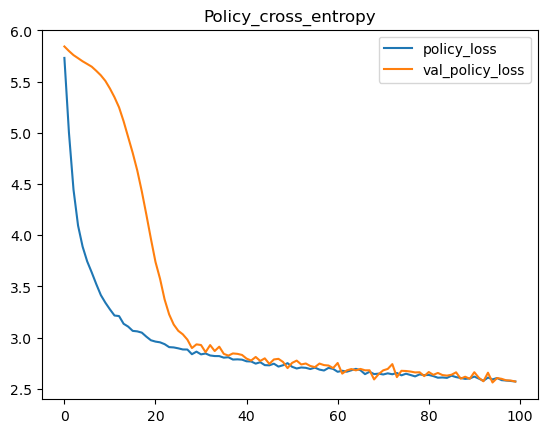

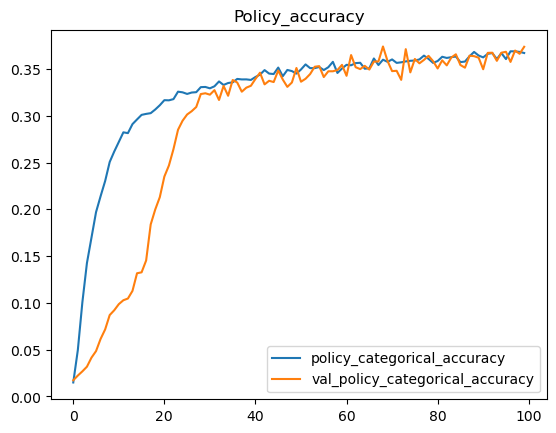

In [7]:
history_df_residualNet.loc[0:, ['policy_loss', 'val_policy_loss']].plot(title="Policy_cross_entropy")
history_df_residualNet.loc[:, ['policy_categorical_accuracy', 'val_policy_categorical_accuracy']].plot(
    title="Policy_accuracy")
print("Minimum Policy Validation Loss: {:0.4f}".format(history_df_residualNet['val_policy_loss'].min()));
print("Maximum Policy Validation Accuracy: {:0.4f}".format(
    history_df_residualNet['val_policy_categorical_accuracy'].max()));

Minimum Value Validation Loss: 0.6333
Minimum Value Validation MSE: 0.0907


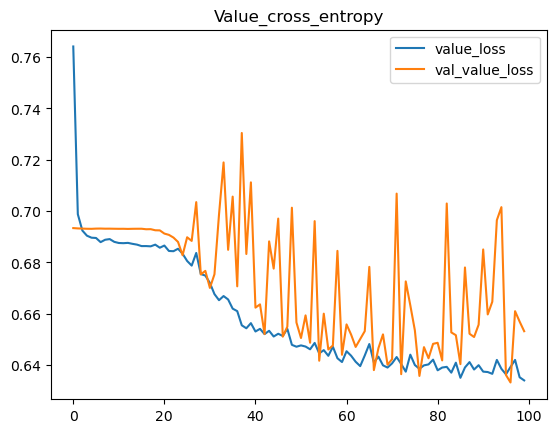

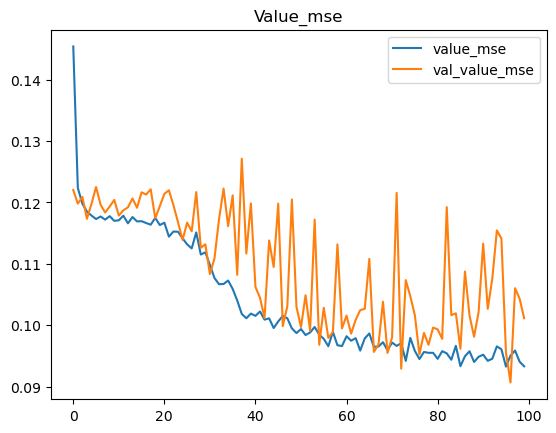

In [8]:
history_df_residualNet.loc[0:, ['value_loss', 'val_value_loss']].plot(title="Value_cross_entropy")
history_df_residualNet.loc[:, ['value_mse', 'val_value_mse']].plot(title="Value_mse")
print("Minimum Value Validation Loss: {:0.4f}".format(history_df_residualNet['val_value_loss'].min()));
print("Minimum Value Validation MSE: {:0.4f}".format(history_df_residualNet['val_value_mse'].min()));

## 4. Choix du modèle final

Pour les données de test, nous avons obtenu : 
- un modèle MobileNet avec une Accuracy de 0.3564 pour la Policy et un MSE de 0.1165 pour la Value,
- un modèle ShuffleNet avec une Accuracy de 0.3729 pour la Policy et un MSE de 0.1942 pour la Value.
- un modèle ResidualNet avec une Accuracy de 0.3657 pour la Policy et un MSE de 0.0991 pour la Value.


Nous choisissons donc le modèle ShuffleNet comme modèle final, car il a obtenu la meilleure précision dans sa Policy.

